# Import data and stuff

In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-04-20 21:01:47.673516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-20 21:01:47.673572: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_df = pd.read_csv('./run2.csv')
data_df = data_df[data_df["speed_avg"] < 600]
data_df = data_df[["duty_cycle","speed_avg"]]
X = data_df.to_numpy()

In [3]:
data_df.corr()

,duty_cycle,speed_avg
duty_cycle,1.000000,0.869815
speed_avg,0.869815,1.000000


In [4]:
data_df

,duty_cycle,speed_avg
0,47,246.428158
1,45,259.895864
2,42,270.464729
3,42,281.724724
4,41,301.669997
...,...,...
4005,100,530.234599
4006,100,537.594669
4007,100,537.241391
4008,100,534.906953


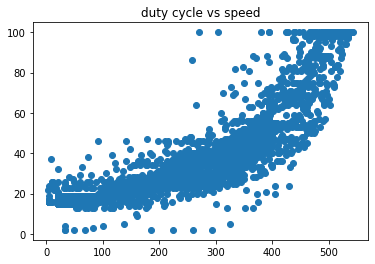

In [5]:
plt.figure()
plt.title("duty cycle vs speed")
plt.scatter(X[:,1],X[:,0]);

Given this correlation, `duty_cycle` and `speed_avg` are well correlated, but not perfectly.

In [6]:
linreg = LinearRegression()
voltage = X[:,0].reshape(-1,1)
speed = X[:,1].reshape(-1,1)
linreg.fit(speed,voltage)
predicted_voltage = linreg.predict(speed)
linreg.score(speed,voltage)

0.7565777246563734

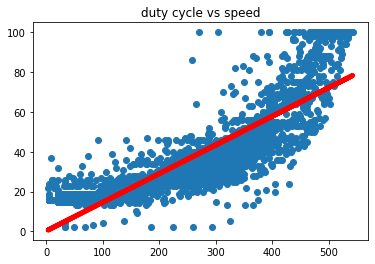

In [7]:
plt.figure()
plt.title("duty cycle vs speed")
plt.scatter(speed,voltage)
plt.plot(speed,predicted_voltage,color="red",linewidth=5.0);

In [8]:
np.sqrt(np.mean((predicted_voltage-voltage)**2))

10.790383704548834

Not a bad RMSE, but about 10% off is a lot.

### Normalize for neuralnets

In [10]:
speed_scaler = MinMaxScaler()
speed_scaler.fit(speed)
speed_scaled = speed_scaler.transform(speed)

In [12]:
model = keras.Sequential(
    [
        keras.Input(shape=(1,)),
        layers.Dense(12, activation="sigmoid", name="layer1"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 12)                24        
                                                                 
 out (Dense)                 (None, 1)                 13        
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


2022-04-20 09:20:00.923588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-20 09:20:00.923669: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-20 09:20:00.925035: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2022-04-20 09:20:00.925640: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.fit(speed_scaled, voltage / 100, epochs=250)

Epoch 1/250
125/125 [==============================] - 2s 6ms/step - loss: 0.0442
Epoch 2/250
125/125 [==============================] - 1s 7ms/step - loss: 0.0207
Epoch 3/250
125/125 [==============================] - 1s 7ms/step - loss: 0.0115
Epoch 4/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0102
Epoch 5/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 6/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0097
Epoch 7/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 8/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0093
Epoch 9/250
125/125 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 10/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0090
Epoch 11/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 12/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 13/250


125/125 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 197/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0055
Epoch 198/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 199/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 200/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 201/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 202/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 203/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 204/250
125/125 [==============================] - 1s 4ms/step - loss: 0.0055
Epoch 205/250
125/125 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 206/250
125/125 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 207/250
125/125 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 

### Plotting the neural net output

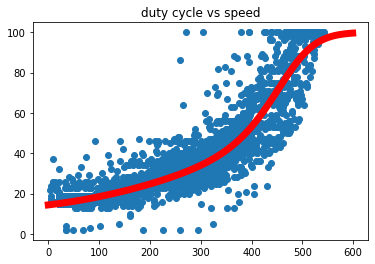

In [15]:
test_a = speed_scaler.transform(np.array(range(600)).reshape(-1,1))
predicted_voltage = model.predict(test_a) * 100
# Y = min_max_scaler_b.inverse_transform(Y_scaled)

plt.figure()
plt.title("duty cycle vs speed")
plt.scatter(speed,voltage)
plt.plot(np.array(range(600)).reshape(-1,1),predicted_voltage,color="red",linewidth=7.0);

In [16]:
predicted_voltage = model.predict(speed_scaler.transform(speed)) * 100
np.sqrt(np.mean((predicted_voltage-voltage)**2))

7.45085063608977

Slightly better. 7.5% off though.

# With acceleration

Maybe acceleration gives us more context?

In [19]:
data_df = pd.read_csv('./run2.csv')
data_df = data_df[data_df["speed_avg"] < 600]
data_df = data_df[["duty_cycle","acc","speed_avg"]]
X = data_df.to_numpy()

### Linreg again

In [23]:
linreg = LinearRegression()
voltage = X[:,0].reshape(-1,1)
X_actual = X[:,1:]
linreg.fit(X_actual,voltage)
predicted_voltage = linreg.predict(X_actual)
linreg.score(X_actual,voltage)

0.7583845405246178

In [24]:
np.sqrt(np.mean((predicted_voltage-voltage)**2))

10.750262993837906

So linear regression doesn't really do any better.

### Neural net again

In [25]:
model = keras.Sequential(
    [
        keras.Input(shape=(2,)),
        layers.Dense(12, activation="sigmoid", name="layer1"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 12)                36        
                                                                 
 out (Dense)                 (None, 1)                 13        
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [26]:
X_scaler = MinMaxScaler()
X_scaler.fit(X_actual)
X_scaled = X_scaler.transform(X_actual)

In [28]:
X_scaler.data_max_, X_scaler.data_min_, X_scaler.data_range_

(array([  4.73178413, 542.65274408]),
 array([-4.02297436,  3.8461747 ]),
 array([  8.75475849, 538.80656938]))

In [29]:
model.fit(X_scaled, voltage / 100, epochs=250)

Epoch 1/250
125/125 [==============================] - 1s 3ms/step - loss: 0.0380
Epoch 2/250
125/125 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 3/250
125/125 [==============================] - 0s 4ms/step - loss: 0.0111
Epoch 4/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 5/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 6/250
125/125 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 7/250
125/125 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 8/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 9/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 10/250
125/125 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 11/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 12/250
125/125 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 13/250


125/125 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 197/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 198/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 199/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 200/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 201/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 202/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 203/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 204/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 205/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 206/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 207/250
125/125 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 

In [30]:
predicted_voltage = model.predict(X_scaled) * 100
np.sqrt(np.mean((predicted_voltage-voltage)**2))

7.261677550334719

Rmse is a bit better. Still not amazing.

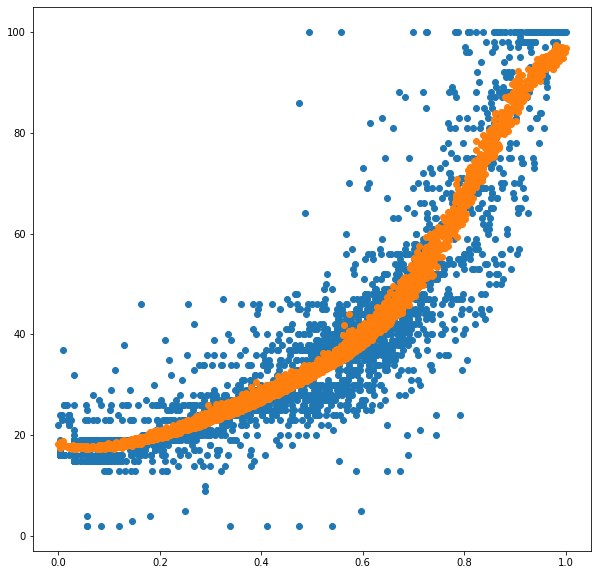

In [31]:
speed = X_scaled[:,1]
plt.figure(figsize=(10,10))
plt.scatter(speed, voltage)
plt.scatter(speed, predicted_voltage)

A tiny bit better now. The graph has a nicer spread.

# Basic RNN

An RNN would probably be great here. Let's try.

### Define lookback as `N`

In [36]:
N = 10

### Let's try a simple RNN first.

In [146]:
model = keras.Sequential(
    [
        keras.Input(shape=(N,2)),
        layers.SimpleRNN(12, name="rnnlayer"),
        layers.Dense(12, activation="sigmoid", name="layer2"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnnlayer (SimpleRNN)        (None, 12)                180       
                                                                 
 layer2 (Dense)              (None, 12)                156       
                                                                 
 out (Dense)                 (None, 1)                 13        
                                                                 
Total params: 349
Trainable params: 349
Non-trainable params: 0
_________________________________________________________________


### Get continuous sequences from the data

The data has splits in it whenver a turn was made, so we need to find the parts that are continuous to train on.

### Build training data from the continuous sequences

In [147]:
data_df = pd.read_csv('./run2.csv')
data_df = data_df[data_df["speed_avg"] < 600]
data_df = data_df[["ts","duty_cycle","acc","speed_avg"]]
X = data_df.to_numpy()

timestamps = X[:,0] 
ts_diffs = timestamps[1:] - timestamps[:-1]

sequences = []
current_sequence = []

for i, diff in enumerate(ts_diffs):
    if diff < 101:
        current_sequence.append(i)
    else:
        if len(current_sequence) > N * 2:
            sequences.append(current_sequence)
        current_sequence = [i]
        
print(len(sequences))

X_relevant = X[:,2:]
Xs_scaler = MinMaxScaler()
Xs_scaler.fit(X_relevant)
X_relevant = Xs_scaler.transform(X_relevant)

# for sequence in sequences:
from sklearn.utils import shuffle

all_Xs = []
all_Ys = []
for sequence in sequences[:]:
#     if len(sequence) < 100:
#         continue
    Xs = []
    Ys = []
    for n in sequence[N:]:
        indexes_x = np.arange(n-N,n)
        index_y = n
        Ys.append(X[index_y,1])
        Xs.append(X_relevant[indexes_x])
    all_Xs += Xs
    all_Ys += Ys

all_Xs = np.array(all_Xs)
all_Ys = np.array(all_Ys).reshape(-1,1)

all_Xs, all_Ys = shuffle(all_Xs,all_Ys)

print(all_Xs.shape, all_Ys.shape)

38
(3793, 3, 2) (3793, 1)


In [148]:
model.fit(all_Xs, all_Ys/100, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
119/119 [==============================] - 1s 2ms/step - loss: 0.0164
Epoch 2/100
119/119 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 3/100
119/119 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 4/100
119/119 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 5/100
119/119 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 6/100
119/119 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 7/100
119/119 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 8/100
119/119 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 9/100
119/119 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 10/100
119/119 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 11/100
119/119 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 12/100
119/119 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 13/100


In [145]:
rmse_sum = 0
num = 0

original_x = []
original_y = []
pred_y = []

for sequence in sequences[:]:
    print()
    X_sequence = X[np.array(sequence)]
    Xs = []
    Ys = []
    OgX = []
    for n in sequence[N:]:
        indexes_x = np.arange(n-N,n)
        index_y = n
        Ys.append(X[index_y,1])
        OgX.append(X[index_y,3])
        Xs.append(X_relevant[indexes_x])
    Xs = np.array(Xs)
    Ys = np.array(Ys).reshape(-1,1)
    print(f"len: {len(sequence)}, mean: {Ys.mean()}, std: {Ys.std()}")
    voltages_pred = model.predict(Xs) * 100
    
    original_x += OgX
    pred_y += list(voltages_pred.flatten())
    original_y += list(Ys.flatten())
    
    rmse = np.sqrt(np.mean((voltages_pred - Ys)**2))
    rmse_sum += (rmse * len(sequence))
    num += len(sequence)
    print(f"rmse: {rmse:.2f}")

print(len(original_x), len(original_y))
rmse_sum / num


len: 128, mean: 40.68, std: 8.46319088760262


ValueError: in user code:

    File "/home/drg101/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/home/drg101/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/drg101/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/home/drg101/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/home/drg101/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/drg101/.local/lib/python3.9/site-packages/keras/engine/input_spec.py", line 247, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_15" (type Sequential).
    
    Input 0 of layer "layer1" is incompatible with the layer: expected axis -1of input shape to have value 3, but received input with shape (None, 3, 2)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 3, 2), dtype=float32)
      • training=False
      • mask=None


Rmse of 4.1 is much better!

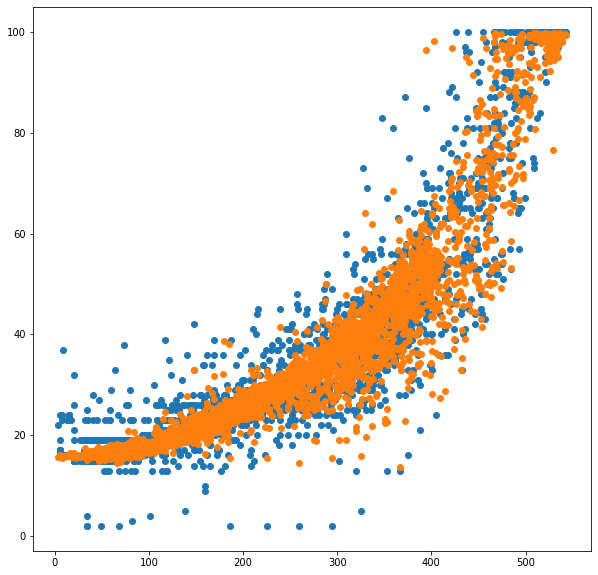

In [42]:
plt.figure(figsize=(10,10))
plt.scatter(original_x, original_y)
plt.scatter(original_x, pred_y)

In [43]:
from keras.models import save_model

save_model(model, "best_model_ever.h5")

### Lets try lstm

In [44]:
model = keras.Sequential(
    [
        keras.Input(shape=(N,2)),
        layers.LSTM(12, name="rnnlayer"),
        layers.Dense(12, activation="sigmoid", name="layer2"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnnlayer (LSTM)             (None, 12)                720       
                                                                 
 layer2 (Dense)              (None, 12)                156       
                                                                 
 out (Dense)                 (None, 1)                 13        
                                                                 
Total params: 889
Trainable params: 889
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit(all_Xs, all_Ys/100, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
110/110 [==============================] - 5s 11ms/step - loss: 0.0184
Epoch 2/100
110/110 [==============================] - 1s 12ms/step - loss: 0.0091
Epoch 3/100
110/110 [==============================] - 1s 11ms/step - loss: 0.0062
Epoch 4/100
110/110 [==============================] - 1s 12ms/step - loss: 0.0048
Epoch 5/100
110/110 [==============================] - 1s 12ms/step - loss: 0.0043
Epoch 6/100
110/110 [==============================] - 1s 11ms/step - loss: 0.0038
Epoch 7/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0035
Epoch 8/100
110/110 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 9/100
110/110 [==============================] - 1s 12ms/step - loss: 0.0033
Epoch 10/100
110/110 [==============================] - 1s 11ms/step - loss: 0.0032
Epoch 11/100
110/110 [==============================] - 1s 13ms/step - loss: 0.0029
Epoch 12/100
110/110 [==============================] - 1s 13ms/step - loss: 0.0029
E

In [46]:
rmse_sum = 0
num = 0

original_x = []
original_y = []
pred_y = []

for sequence in sequences[:]:
    print()
    X_sequence = X[np.array(sequence)]
    Xs = []
    Ys = []
    OgX = []
    for n in sequence[N:]:
        indexes_x = np.arange(n-N,n)
        index_y = n
        Ys.append(X[index_y,1])
        OgX.append(X[index_y,3])
        Xs.append(X_relevant[indexes_x])
    Xs = np.array(Xs)
    Ys = np.array(Ys).reshape(-1,1)
    print(f"len: {len(sequence)}, mean: {Ys.mean()}, std: {Ys.std()}")
    voltages_pred = model.predict(Xs) * 100
    
    original_x += OgX
    pred_y += list(voltages_pred.flatten())
    original_y += list(Ys.flatten())
    
    rmse = np.sqrt(np.mean((voltages_pred - Ys)**2))
    rmse_sum += (rmse * len(sequence))
    num += len(sequence)
    print(f"rmse: {rmse:.2f}")

print(len(original_x), len(original_y))
rmse_sum / num


len: 128, mean: 40.567796610169495, std: 8.68319906443074
rmse: 4.20

len: 124, mean: 43.12280701754386, std: 5.454983800251233
rmse: 3.43

len: 276, mean: 35.53007518796993, std: 10.800699538486503
rmse: 4.32

len: 131, mean: 47.37190082644628, std: 23.489801631439537
rmse: 8.61

len: 99, mean: 18.786516853932586, std: 4.746310004014732
rmse: 3.32

len: 599, mean: 19.3616298811545, std: 2.099386617232461
rmse: 1.73

len: 195, mean: 24.12972972972973, std: 5.732263590668169
rmse: 2.89

len: 101, mean: 29.01098901098901, std: 3.296666666463164
rmse: 2.04

len: 68, mean: 26.103448275862068, std: 3.822301415298587
rmse: 1.77

len: 40, mean: 23.5, std: 0.5
rmse: 1.11

len: 63, mean: 27.943396226415093, std: 3.074024430855291
rmse: 2.87

len: 33, mean: 27.0, std: 0.0
rmse: 1.65

len: 85, mean: 27.0, std: 0.0
rmse: 1.64

len: 310, mean: 34.483333333333334, std: 20.11706710454804
rmse: 4.02

len: 90, mean: 61.125, std: 30.45298630676473
rmse: 8.63

len: 53, mean: 52.02325581395349, std: 19.6

3.9182712199042244

Even better!

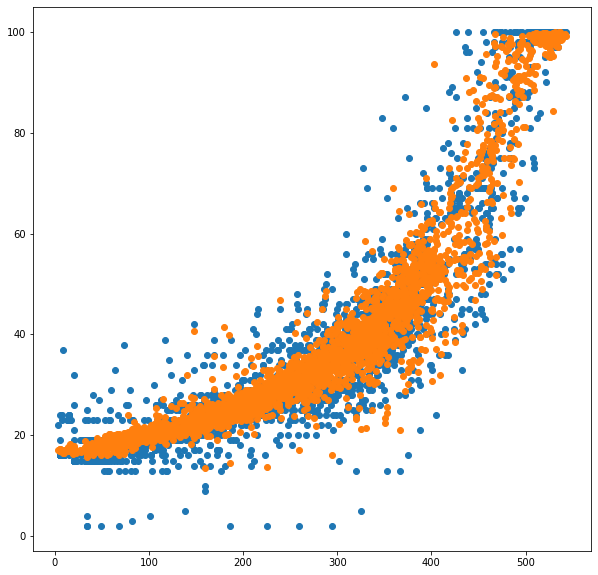

In [48]:
plt.figure(figsize=(10,10))
plt.scatter(original_x, original_y)
plt.scatter(original_x, pred_y)

### Overkill LSTM

Our RNN clearly fits our data pretty well. Let's make it much bigger and see how it does.

In [52]:
model = keras.Sequential(
    [
        keras.Input(shape=(N,2)),
        layers.LSTM(64, name="rnnlayer"),
        layers.Dense(64, activation="relu", name="layer1"),
        layers.Dense(128, activation="relu", name="layer2"),
        layers.Dense(64, activation="relu", name="layer3"),
        layers.Dense(1, name='out', activation='sigmoid')
    ]
)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnnlayer (LSTM)             (None, 64)                17152     
                                                                 
 layer1 (Dense)              (None, 64)                4160      
                                                                 
 layer2 (Dense)              (None, 128)               8320      
                                                                 
 layer3 (Dense)              (None, 64)                8256      
                                                                 
 out (Dense)                 (None, 1)                 65        
                                                                 
Total params: 37,953
Trainable params: 37,953
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.fit(all_Xs, all_Ys/100, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
110/110 [==============================] - 6s 13ms/step - loss: 0.0136
Epoch 2/100
110/110 [==============================] - 1s 13ms/step - loss: 0.0043
Epoch 3/100
110/110 [==============================] - 2s 14ms/step - loss: 0.0046
Epoch 4/100
110/110 [==============================] - 1s 14ms/step - loss: 0.0048
Epoch 5/100
110/110 [==============================] - 2s 14ms/step - loss: 0.0035
Epoch 6/100
110/110 [==============================] - 2s 16ms/step - loss: 0.0038
Epoch 7/100
110/110 [==============================] - 2s 14ms/step - loss: 0.0035
Epoch 8/100
110/110 [==============================] - 1s 13ms/step - loss: 0.0030
Epoch 9/100
110/110 [==============================] - 1s 13ms/step - loss: 0.0034
Epoch 10/100
110/110 [==============================] - 2s 14ms/step - loss: 0.0030
Epoch 11/100
110/110 [==============================] - 1s 13ms/step - loss: 0.0030
Epoch 12/100
110/110 [==============================] - 1s 13ms/step - loss: 0.0030
E

In [54]:
rmse_sum = 0
num = 0

original_x = []
original_y = []
pred_y = []

for sequence in sequences[:]:
    print()
    X_sequence = X[np.array(sequence)]
    Xs = []
    Ys = []
    OgX = []
    for n in sequence[N:]:
        indexes_x = np.arange(n-N,n)
        index_y = n
        Ys.append(X[index_y,1])
        OgX.append(X[index_y,3])
        Xs.append(X_relevant[indexes_x])
    Xs = np.array(Xs)
    Ys = np.array(Ys).reshape(-1,1)
    print(f"len: {len(sequence)}, mean: {Ys.mean()}, std: {Ys.std()}")
    voltages_pred = model.predict(Xs) * 100
    
    original_x += OgX
    pred_y += list(voltages_pred.flatten())
    original_y += list(Ys.flatten())
    
    rmse = np.sqrt(np.mean((voltages_pred - Ys)**2))
    rmse_sum += (rmse * len(sequence))
    num += len(sequence)
    print(f"rmse: {rmse:.2f}")

print(len(original_x), len(original_y))
rmse_sum / num


len: 128, mean: 40.567796610169495, std: 8.68319906443074
rmse: 4.27

len: 124, mean: 43.12280701754386, std: 5.454983800251233
rmse: 3.54

len: 276, mean: 35.53007518796993, std: 10.800699538486503
rmse: 4.37

len: 131, mean: 47.37190082644628, std: 23.489801631439537
rmse: 7.89

len: 99, mean: 18.786516853932586, std: 4.746310004014732
rmse: 2.71

len: 599, mean: 19.3616298811545, std: 2.099386617232461
rmse: 2.17

len: 195, mean: 24.12972972972973, std: 5.732263590668169
rmse: 2.72

len: 101, mean: 29.01098901098901, std: 3.296666666463164
rmse: 2.41

len: 68, mean: 26.103448275862068, std: 3.822301415298587
rmse: 2.07

len: 40, mean: 23.5, std: 0.5
rmse: 1.72

len: 63, mean: 27.943396226415093, std: 3.074024430855291
rmse: 3.03

len: 33, mean: 27.0, std: 0.0
rmse: 1.78

len: 85, mean: 27.0, std: 0.0
rmse: 1.48

len: 310, mean: 34.483333333333334, std: 20.11706710454804
rmse: 3.73

len: 90, mean: 61.125, std: 30.45298630676473
rmse: 7.74

len: 53, mean: 52.02325581395349, std: 19.6

3.8929495386110973

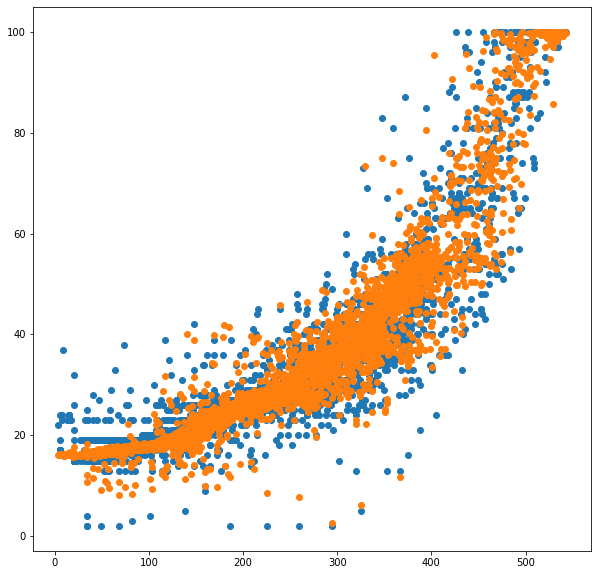

In [55]:
plt.figure(figsize=(10,10))
plt.scatter(original_x, original_y)
plt.scatter(original_x, pred_y)

Really not any better. Not worth the extra computation. Especially since we are doing the computation on the fly.

# A different approach

These approaches have a fatal flaw in the real world. What is the input for `speed` during inference?

In the real world, we have an "actual speed" and a "desired speed"

- actual speed = speed measured by the speed sensor on the vehicle
- desired speed = speed that is being asked for

For our supervised approach, we can assume that the "desired speed" for timestep $X$ is the "actual speed" at timestep $X + N$ where $N$ is how long it takes for a desire to become a reality for a human. 

Let's search for the best $N$ (how long for a desire to become actual).

To do this, we will use the same methods as the previous RNN examples, but instead of creating data with "look back" we instead will have single points with actual/desired based on the defined $N$.

In [13]:
from sklearn.model_selection import train_test_split

In [75]:
data_df = pd.read_csv('./run2.csv')
# data_df_b = pd.read_csv('./run1.csv')
# data_df = pd.concat([data_df_a, data_df_b])

data_df = data_df[data_df["speed_avg"] < 600]
data_df = data_df[["ts","duty_cycle","acc","speed_avg"]]
X = data_df.to_numpy()

results = []

def get_data_n(N):
    timestamps = X[:,0] 
    ts_diffs = timestamps[1:] - timestamps[:-1]

    X_relevant = X[:,2:]
    Xs_scaler = MinMaxScaler()
    Xs_scaler.fit(X_relevant)
    X_relevant = Xs_scaler.transform(X_relevant)

    sequences = []
    current_sequence = []

    for i, diff in enumerate(ts_diffs):
        if diff < 101:
            current_sequence.append(i)
        else:
            if len(current_sequence) > N * 2:
                sequences.append(current_sequence)
            current_sequence = [i]

    print(f'num cont sequences is {len(sequences)}')

    all_Xs = []
    all_Ys = []
    for sequence in sequences[:]:
        Xs = []
        Ys = []
        for n in sequence[:-N]:
            index_actual = n
            index_desired = n + N
            Ys.append(X[index_actual,1])
            x_val = np.hstack((X_relevant[index_actual],X_relevant[index_desired, 1]))
    #         print(x_val)
            Xs.append(x_val)
        all_Xs += Xs
        all_Ys += Ys

    all_Xs = np.array(all_Xs)
    all_Ys = np.array(all_Ys).reshape(-1,1)
    return all_Xs, all_Ys

def test_n(N, verbose=0):
    all_Xs,all_Ys = get_data_n(N)

    train_Xs, test_Xs, train_Ys, test_Ys  = train_test_split(all_Xs, all_Ys, test_size=0.25, random_state=42)
    
    # -------------
    
    model = keras.Sequential(
        [
            keras.Input(shape=(3,)),
            layers.Dense(6, activation="sigmoid", name="layer1"),
            layers.Dense(6, activation="sigmoid", name="layer2"),
            layers.Dense(6, activation="sigmoid", name="layer3"),
            layers.Dense(1, name='out', activation='sigmoid')
        ]
    )
#     model.summary()
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mean_squared_error', optimizer=opt)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    mc = tf.keras.callbacks.ModelCheckpoint('best_contextual_model.h5', monitor='val_loss', mode='min')
    model.fit(train_Xs, train_Ys/100, validation_data=(test_Xs,test_Ys/100), epochs=5000, batch_size=32, verbose=verbose, callbacks=[es,mc])
    
    train_predicted_voltage = model.predict(train_Xs) * 100
    train_rmse = np.sqrt(np.mean((train_predicted_voltage-train_Ys)**2))
    
    test_predicted_voltage = model.predict(test_Xs) * 100
    test_rmse = np.sqrt(np.mean((test_predicted_voltage-test_Ys)**2))
    
    results.append([N,train_rmse,test_rmse])
    print(f"{N} got {train_rmse} - {test_rmse}")
    return model


In [76]:
model = test_n(3,verbose=1)

num cont sequences is 38
Epoch 1/5000
89/89 [==============================] - 1s 4ms/step - loss: 0.0397 - val_loss: 0.0431
Epoch 2/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0194 - val_loss: 0.0103
Epoch 3/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0062
Epoch 4/5000
89/89 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 5/5000
89/89 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 6/5000
89/89 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 7/5000
89/89 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 8/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 9/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/5000
89/89 [==============================] - 0s 3ms/step - loss: 

Epoch 82/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 83/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 84/5000
89/89 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 85/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 86/5000
89/89 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 87/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 88/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 89/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 90/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 91/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0015 - val_los

89/89 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 163/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 164/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 165/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 166/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 167/5000
89/89 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 168/5000
89/89 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0012
3 got 3.663210631320248 - 3.5090713167747998


In [53]:
models = [test_n(n) for n in range(1,11)]

num cont sequences is 184
1 got 8.868469373491184 - 8.406702376699407
num cont sequences is 175
2 got 7.688223019384122 - 7.597313957277816
num cont sequences is 167
3 got 7.799938604598608 - 7.81102418995113
num cont sequences is 159
4 got 9.012733267659335 - 8.466802569552486
num cont sequences is 150
5 got 10.563246883621638 - 10.809016051444539
num cont sequences is 142
6 got 10.369658277833615 - 10.221386444896783
num cont sequences is 135
7 got 10.13350213018972 - 10.407469388276702
num cont sequences is 129
8 got 10.346998984537032 - 10.096162992465745
num cont sequences is 127
9 got 10.555919076103642 - 10.449617243460613
num cont sequences is 119
10 got 11.155908981638254 - 10.528213576160148


In [65]:
results = np.array(results)
pd.DataFrame(results, columns=['N', 'train rmse', 'test rmse'])

,N,train rmse,test rmse
0,3.0,4.204415,4.354611


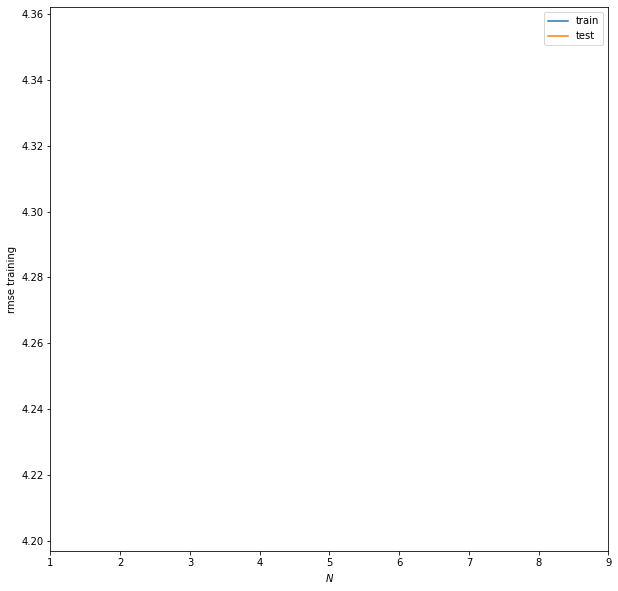

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(results[:,0],results[:,1], label="train")
plt.plot(results[:,0],results[:,2], label="test")
ax.set_xticks(np.arange(1,10))
plt.legend(loc="upper right")
plt.xlabel('$N$')
plt.ylabel("rmse training")
plt.show()

It looks like 3 or 4 are great options.

### Simple Neural Net

In [77]:
all_Xs,all_Ys = get_data_n(3)
predicted_voltage = model.predict(all_Xs) * 100
np.sqrt(np.mean((predicted_voltage-all_Ys)**2))

num cont sequences is 38


3.6252601438226026

In [79]:
model.predict([[0,1,0]])

array([[0.09058878]], dtype=float32)

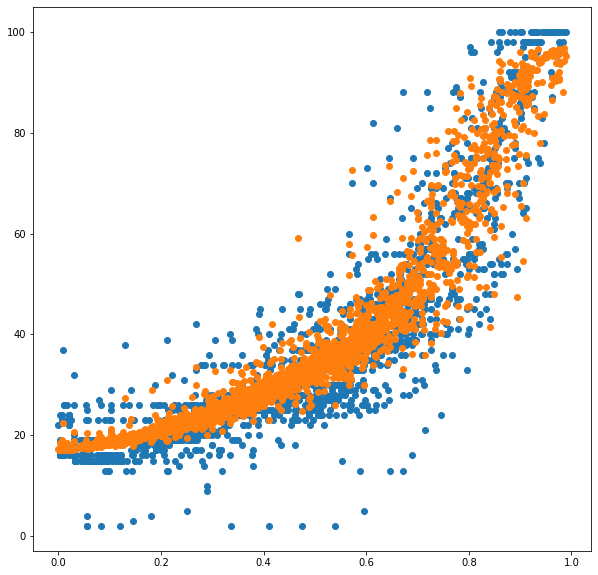

In [72]:
# %matplotlib notebook


speed = all_Xs[:,1]
speed2 = all_Xs[:,2]
num_to_plot = 3000
samples_to_plot = np.random.randint(0,len(speed) - num_to_plot)
plt.figure(figsize=(10,10))
# ax = plt.axes(projection='3d')
# print(len(speed))
plt.scatter(speed[samples_to_plot:samples_to_plot+num_to_plot], all_Ys[samples_to_plot:samples_to_plot+num_to_plot])
plt.scatter(speed[samples_to_plot:samples_to_plot+num_to_plot], predicted_voltage[samples_to_plot:samples_to_plot+num_to_plot])

# ax.scatter3D(speed[samples_to_plot:samples_to_plot+num_to_plot], speed2[samples_to_plot:samples_to_plot+num_to_plot], all_Ys[samples_to_plot:samples_to_plot+num_to_plot], cmap='Greens')
# ax.scatter3D(speed[samples_to_plot:samples_to_plot+num_to_plot], speed2[samples_to_plot:samples_to_plot+num_to_plot], predicted_voltage[samples_to_plot:samples_to_plot+num_to_plot], cmap='Red')
# ax.set_xlabel('actual speed', fontsize=20)
# ax.set_ylabel('desired speed', fontsize=20)
# ax.set_zlabel('voltage', fontsize=20);

Weird. But better.

In [80]:
from keras.models import save_model

save_model(model, "contextual_model.h5")